<a href="https://colab.research.google.com/github/tawhidliyon/Machine-Learning/blob/main/emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import requests
import zipfile
import os
from tqdm import tqdm

def download_and_extract_zip(url, extract_dir='downloaded_content'):
    # Create the directory if it doesn't exist
    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir)

    # Extract filename from the URL
    filename = url.split('/')[-1]
    filepath = os.path.join(extract_dir, filename)

    # Download the file with progress bar
    print(f"Downloading {filename}...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(filepath, 'wb') as file, tqdm(
        desc=filename,
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)

    # Extract the zip file
    print(f"Extracting contents to {extract_dir}...")
    with zipfile.ZipFile(filepath, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    # Clean up - remove the zip file after extraction
    os.remove(filepath)
    print(f"Done! All contents extracted to {extract_dir}")

# URL from your command
url = "https://zenodo.org/records/1188976/files/Audio_Song_Actors_01-24.zip"

# Run the function
if __name__ == "__main__":
    download_and_extract_zip(url)

Audio_Song_Actors_01-24.zip: 100%|██████████| 215M/215M [00:19<00:00, 11.5MB/s]


Extracting contents to downloaded_content...
Done! All contents extracted to downloaded_content


In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


In [2]:
# Path to the RAVDESS dataset
data_path = '/content/downloaded_content'

# Initialize variables to hold the features and labels
features = []
labels = []

# Define emotions corresponding to the RAVDESS dataset
emotion_labels = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Function to extract MFCC features from audio
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, sr=None)
    # Changed to pass 'audio' and 'sr' as keyword arguments
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    return np.mean(mfcc, axis=1)

# Loop through files in the dataset directory
for root, dirs, files in os.walk(data_path): # Added os.walk to traverse subdirectories
    for filename in files:
        if filename.endswith(".wav"):
            # Construct the full file path
            file_path = os.path.join(root, filename)

            # Extract emotion label from filename
            emotion_code = filename.split('-')[2]
            emotion = emotion_labels[emotion_code]

            # Extract features
            feature = extract_features(file_path)

            features.append(feature)
            labels.append(emotion)

# Convert features and labels into numpy arrays
features = np.array(features)
labels = np.array(labels)

# Encode labels as integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded)  # One-hot encoding

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

# Reshape input for LSTM (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
num_classes = y_train.shape[1]

In [7]:
# Build a simple LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dropout(0.2))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
history = model.fit(X_train, y_train, epochs=300, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.1917 - loss: 1.7896 - val_accuracy: 0.2808 - val_loss: 1.7676
Epoch 2/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2168 - loss: 1.7647 - val_accuracy: 0.2365 - val_loss: 1.7517
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1985 - loss: 1.7702 - val_accuracy: 0.2217 - val_loss: 1.7357
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2412 - loss: 1.7509 - val_accuracy: 0.2167 - val_loss: 1.7147
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2745 - loss: 1.7063 - val_accuracy: 0.2463 - val_loss: 1.6660
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2772 - loss: 1.6914 - val_accuracy: 0.2956 - val_loss: 1.6214
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3051 - loss: 1.6591 - val_accuracy: 0.2906 - val_loss: 1.5866
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2921 - loss: 1.6653 - val_accuracy: 0.

In [9]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5071 - loss: 1.1655 
Test Accuracy: 50.74%


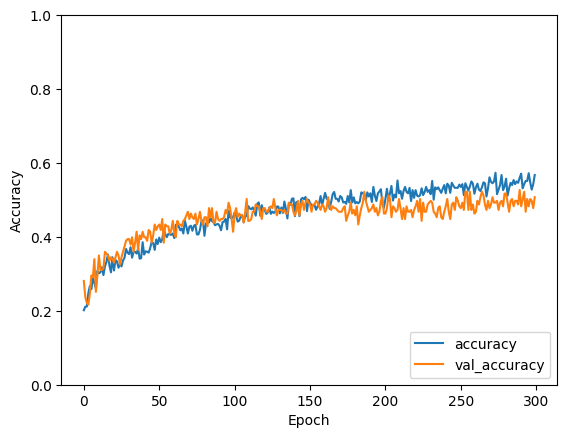

In [10]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [17]:
# Path to your own WAV file
sample_path = '/content/test.wav'

# Function to preprocess the WAV sample
def preprocess_sample(file_path):
    # Load the audio file
    audio, sample_rate = librosa.load(file_path, sr=None)
    # Extract MFCC features
    # Changed to pass 'audio' and 'sr' as keyword arguments
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    # Take the mean of each MFCC coefficient over time
    feature = np.mean(mfcc, axis=1)
    return feature

# Preprocess the sample
sample_features = preprocess_sample(sample_path)

# Reshape the sample features for the model
sample_features = sample_features.reshape(1, 1, sample_features.shape[0])  # Shape: (1, 1, n_features)


In [18]:
# Predict the emotion using the trained model
prediction = model.predict(sample_features)

# Get the predicted emotion label
predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])

print(f"Predicted Emotion: {predicted_label[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Emotion: angry


In [20]:
# Emotion labels mapping (same as before)
emotion_map = {
    'neutral': '01',
    'calm': '02',
    'happy': '03',
    'sad': '04',
    'angry': '05',
    'fearful': '06',
    'disgust': '07',
    'surprised': '08'
}

# Display emotion prediction
print(f"Predicted Emotion Code: {emotion_map[predicted_label[0]]}")


Predicted Emotion Code: 05
